###setup

In [1]:
%matplotlib inline

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from numpy import array, inf, maximum
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
import thunder
from showit import image, tile
import matplotlib.animation as animation

In [4]:
from os.path import join, exists
from os import mkdir, makedirs
import pandas as pd

In [5]:
import regression

In [6]:
from skimage.io import imread, imsave

###set directory and session information

In [7]:
directory = '/tier2/freeman/Nick/mVR/sessions'

In [8]:
key = '000134'
prefix = 'trial'
path = directory + '/' + key
print path
print exists(path)

/tier2/freeman/Nick/mVR/sessions/000134
True


###load covariates

In [9]:
covariates = pd.read_csv(path + '/covariates/covariates.csv')

###load data

In [10]:
data = thunder.images.frombinary(path + '/registered', engine=sc, npartitions = 1000)

In [11]:
from numpy import arange, polyfit, polyval

In [12]:
def detrend(y, order=5):
        """
        Detrend series data with linear or nonlinear detrending.
        Preserve intercept so that subsequent operations can adjust the baseline.
        Parameters
        ----------
        method : str, optional, default = 'linear'
            Detrending method
        order : int, optional, default = 5
            Order of polynomial, for non-linear detrending only
        """

        x = arange(len(y))
        p = polyfit(x, y, order)
        p[-1] = 0
        yy = polyval(p, x)
        return y - yy

In [14]:
detrended = data.map_as_series(lambda x: detrend(x))

In [15]:
detrended.cache()
detrended.compute()

In [18]:
records = detrended.toseries().squelch(50).normalize('mean')

In [19]:
records.cache()
records.compute()

In [20]:
avg = records.mean().toarray()

In [21]:
avg.shape

(8585,)

In [22]:
len(covariates)

8585

In [23]:
covariates.allTime = covariates.allTime.cumsum()

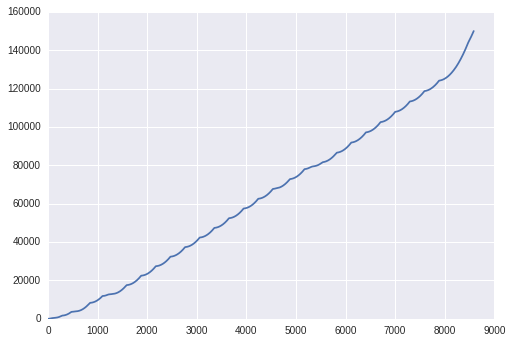

In [24]:
plt.plot(covariates.allTime)

(0, 25000)

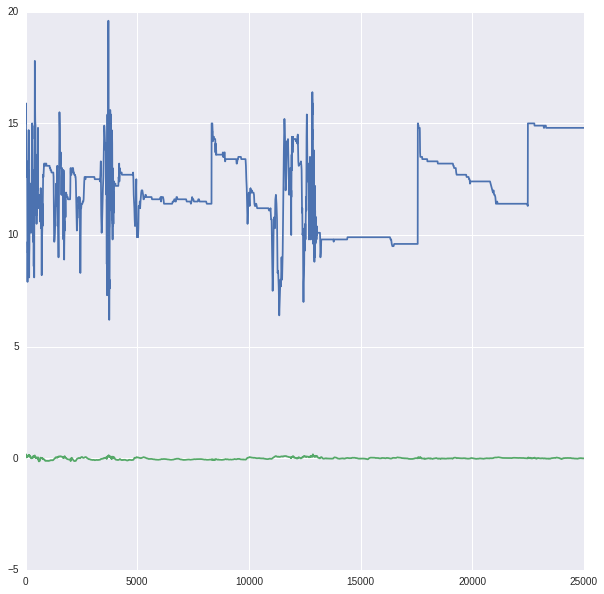

In [25]:
plt.figure(figsize=(10,10))
plt.plot(covariates.allTime, covariates.corPos);
plt.plot(covariates.allTime, avg);
plt.xlim([0, 25000])

##Pixelwise regression demo

In [26]:
import numpy as np
from matplotlib.pyplot import get_cmap
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from regression import LinearRegression

In [27]:
def build_reg(value, scale, debug=False):
    max_val = np.floor(max(value)/scale)*scale
    min_val = np.ceil(min(value)/scale)*scale
    bins = np.arange(min_val,max_val,scale)
    bins = np.concatenate((bins, [np.Inf]))
    design_mat = np.zeros([bins.shape[0] - 1,value.shape[0]])
    for bb in range(bins.shape[0] - 1):
        design_mat[bb,:] = (value >= bins[bb]) & (value < bins[bb+1])
    bins = bins[:-1]
    if debug:
        print 'bins:'
        print bins
        print 'repeats:'
        print design_mat.sum(axis=1)
    return bins, design_mat.transpose()

In [36]:
def do_reg(data, design_mat, bins):
    algorithm = LinearRegression(fit_intercept=False)
    model = algorithm.fit(design_mat, data)
    rsq = model.score(design_mat, data)
    tune = model.betas.map(fitTune)
    return tune.toarray(), rsq.toarray()

In [29]:
def fitTune(b):
    return sum(b.clip(0, inf)[1:]*bins)/sum(b.clip(0, inf)[1:])

In [30]:
def make_map(rsq, tune, cmap=None, vmin=0, vmax=inf, rmin=0, rmax=0.05):
    cmap = get_cmap('rainbow') if cmap is None else cmap
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    img = norm(tune.copy())
    mapped = cmap(img)[:, :, 0:3]
    for i in range(3):
        mapped[:, :, i] *= (rsq.clip(rmin, rmax) - rmin) / (rmax - rmin)
    return mapped

In [31]:
def make_rsq_map(rsq, cmap=None, vmin=0, vmax=inf, threshold=0.05):
    cmap = get_cmap('rainbow') if cmap is None else cmap
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    img = norm(rsq.copy())
    mapped = cmap(img)[:, :, 0:3]
    return mapped

### speed tuning maps

In [32]:
bins, design_mat = build_reg(covariates.speed.values, 4, debug=True)

bins:
[  0.   4.   8.  12.  16.  20.  24.]
repeats:
[ 7557.   388.   270.   182.   107.    58.    23.]


In [37]:
tuning_speed, rsq_speed = do_reg(records, design_mat, bins)

In [38]:
from numpy import asarray

In [39]:
cmap = LinearSegmentedColormap.from_list('blend', [[0, 0, 0], [0.9, 0.25, 0.1]])
#mapped_speed = make_rsq_map(rsq_speed, vmin=0.0, vmax=0.2, cmap=cmap)
mapped_speed = asarray([make_rsq_map(x, vmin=0.0, vmax=0.06, cmap=cmap) for x in rsq_speed])

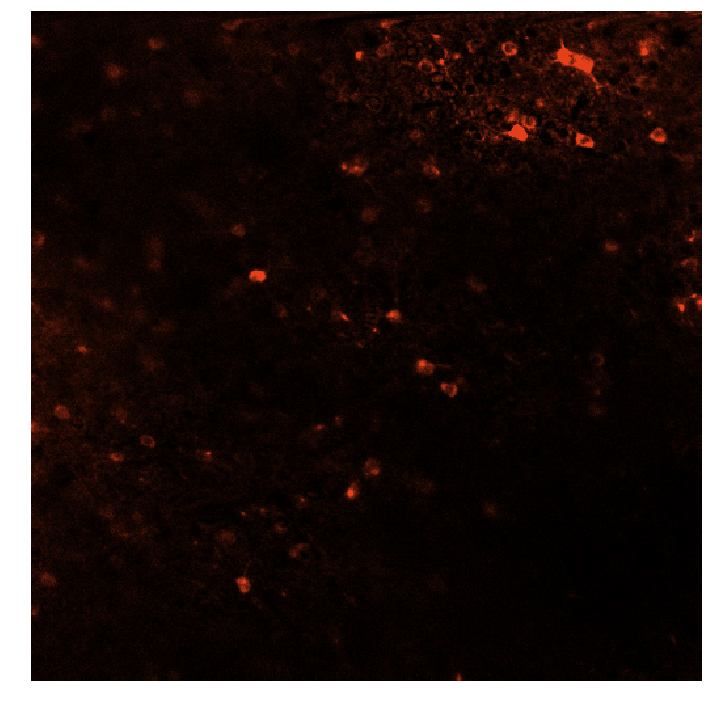

In [44]:
image(mapped_speed[1], size=12)

In [41]:
imsave(path+'/summary/rsqSpeedD.tif', (255*mapped_speed.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

In [ ]:
#mapped_speed = imread(savepath+'/rsqSpeedD.tif', plugin='tifffile').astype('float32')/255

###corridor position maps running

In [46]:
records2 = data[np.where(covariates.speed.values>0)].toseries()
records2 = records2.squelch(50).normalize('mean')
records2.cache()

Series
mode: spark
dtype: float64
shape: (4, 512, 512, 3215)

In [47]:
bins, design_mat = build_reg(covariates.corPos.values[covariates.speed.values>0], 3, debug=True)

bins:
[  3.   6.   9.  12.  15.]
repeats:
[   18.   172.  1435.  1314.   273.]


In [48]:
tuning_corposR, rsq_corposR = do_reg(records2, design_mat, bins)

In [58]:
cmap = LinearSegmentedColormap.from_list('blend', [[0, 0, 0], [0.3, 0.7, 1.0]])
#mapped_corposR = make_rsq_map(rsq_corposR, vmin=0.005, vmax=0.05, cmap=cmap)
mapped_corposR = asarray([make_rsq_map(x, vmin=0.02, vmax=0.15, cmap=cmap) for x in rsq_corposR])

In [50]:
#mapped_corposR = imread(savepath+'/rsqCorPosRD.tif', plugin='tifffile').astype('float32')/255

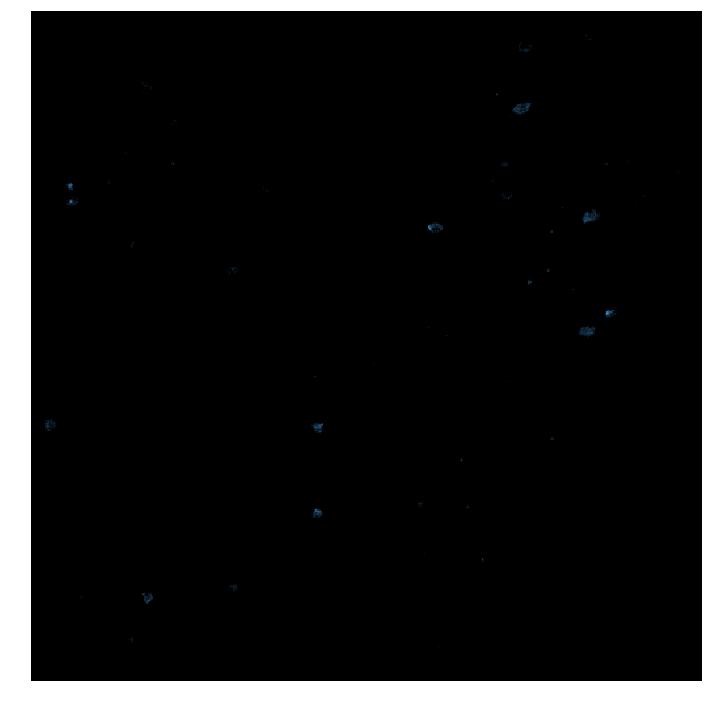

In [59]:
image(mapped_corposR[0], size=12);

In [60]:
imsave(path+'/summary/rsqCorPosRD.tif', (255*mapped_corposR.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

/usr/local/python-2.7.6/lib/python2.7/site-packages/scikit_image-0.11.3-py2.7-linux-x86_64.egg/skimage/io/_io.py:159: UserWarning: /tier2/freeman/Nick/mVR/sessions/000134/summary/rsqCorPosRD.tif is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)


In [61]:
#mappedR = make_map(rsq_corposR, tuning_corposR, vmin=8.5, vmax = 18.5, rmin=0.0, rmax=0.05)
#mappedR = make_map(rsq_corposR, tuning_corposR, vmin=0, vmax = 30, rmin=0.0, rmax=0.05)
mappedR = asarray([make_map(rsq_corposR[i], tuning_corposR[i], vmin=0, vmax = 30, rmin=0.02, rmax=0.15) for i in range(2)])

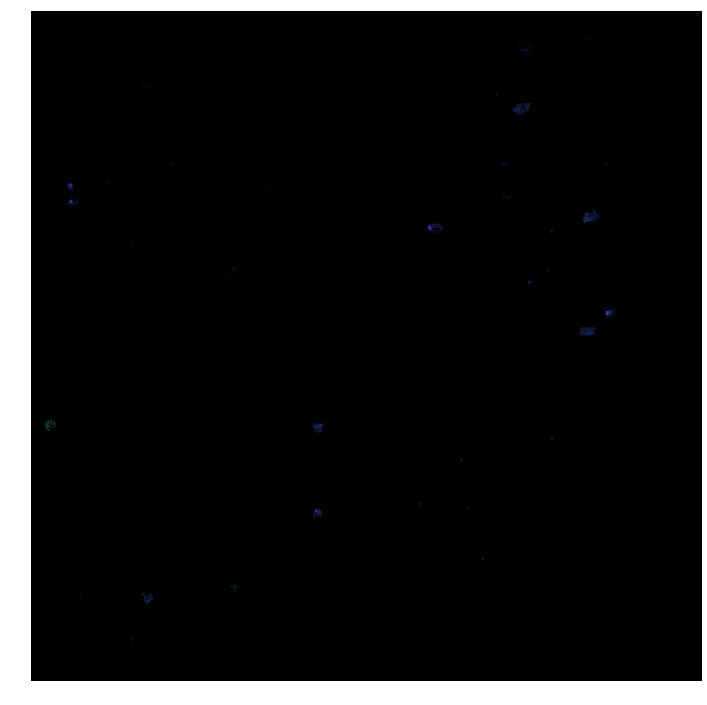

In [63]:
image(mappedR[0].clip(0,1), size=12);

In [64]:
imsave(path+'/summary/tuneCorPosRD.tif', (255*mappedR.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

/usr/local/python-2.7.6/lib/python2.7/site-packages/scikit_image-0.11.3-py2.7-linux-x86_64.egg/skimage/io/_io.py:159: UserWarning: /tier2/freeman/Nick/mVR/sessions/000134/summary/tuneCorPosRD.tif is a low contrast image
  warnings.warn('%s is a low contrast image' % fname)


### corridor position maps

In [65]:
bins, design_mat = build_reg(covariates.corPos.values, 4, debug=True)

bins:
[  4.   8.  12.]
repeats:
[  294.  3014.  5268.]


In [68]:
tuning_corpos, rsq_corpos = do_reg(records, design_mat, bins)

In [69]:
cmap = LinearSegmentedColormap.from_list('blend', [[0, 0, 0], [0.3, 0.7, 1.0]])
#mapped_corpos = make_rsq_map(rsq_corpos, vmin=0.0, vmax=0.05, cmap=cmap)
mapped_corpos = asarray([make_rsq_map(x, vmin=0.0, vmax=0.02, cmap=cmap) for x in rsq_corpos])

In [ ]:
#plt.hist(tuning_corpos[rsq_corpos>.0005].flatten())

In [ ]:
image(mapped_corpos, size=12);

In [ ]:
imsave(path+'/summary/rsqCorPosAD.tif', (255*mapped_corpos.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

In [ ]:
#mapped_corpos = imread(savepath+'/rsqCorPosAD.tif', plugin='tifffile').astype('float32')/255

In [ ]:
mapped = make_map(rsq_corpos, tuning_corpos, vmin=10.5, vmax = 13.5, rmin=0, rmax=0.05)
#mapped = asarray([make_map(rsq_corpos[i], tuning_corpos[i], vmin=10.5, vmax = 13.5, rmin=0, rmax=0.02) for i in range(2)])

In [ ]:
image(mapped.clip(0,1), size=12);

In [ ]:
imsave(path + '/summary/tuneCorPosAD.tif', (255*mapped.clip(0,1)).astype('uint8'), plugin='tifffile', photometric='rgb')

###overlay

In [ ]:
overlay = maximum(mapped_corpos, mapped_speed)

In [ ]:
image(overlay, size=12)

In [ ]:
imsave(path + '/summary/rsqOverlayD.tif', (255*overlay).astype('uint8'), plugin='tifffile', photometric='rgb')

In [ ]:
overlayR = maximum(mapped_corposR, mapped_speed)

In [ ]:
image(overlayR, size=12)

In [ ]:
imsave(path+'/summary/rsqOverlayRD.tif', (255*overlayR).astype('uint8'), plugin='tifffile', photometric='rgb')

### localcorr map

In [ ]:
localcorr = detrended.localcorr((4, 4)).astype('float32')
#localcorr = detrended.localcorr((1, 4, 4)).astype('float32')

In [ ]:
image(localcorr, clim=(0, 3.5*localcorr.mean()), size=12)

In [ ]:
imsave(path + '/summary/localcorrD.tif', localcorr, plugin='tifffile', photometric='minisblack')

In [ ]:
#localcorr = imread(savepath+'/localcorrD.tif')

##overlay

In [87]:
cmap = LinearSegmentedColormap.from_list('blend', [[0, 0, 0], [0.1, 1.0, 0.2]])
mapped_localcorr = make_rsq_map(localcorr, vmin=0.5, vmax=0.9, cmap=cmap)
#mapped_localcorr = asarray([make_rsq_map(x, vmin=0.5, vmax=0.9, cmap=cmap) for x in localcorr])

In [88]:
overlay = maximum(maximum(mapped_corpos, mapped_speed), mapped_localcorr)

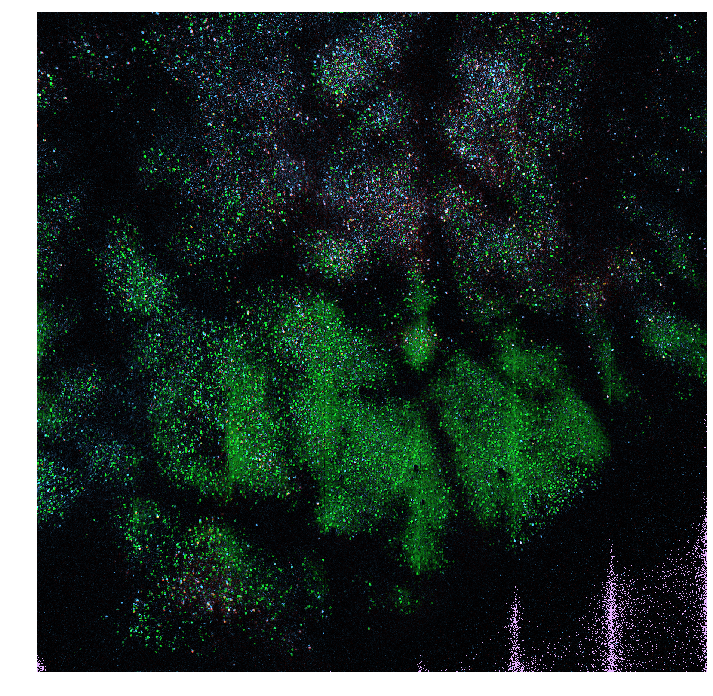

In [89]:
image(overlay, size=12);

In [91]:
imsave(path + '/summary/rsqOverlayLCD.tif', (255*overlay).astype('uint8'), plugin='tifffile', photometric='rgb')

In [92]:
overlayR = maximum(maximum(mapped_corposR, mapped_speed), mapped_localcorr)

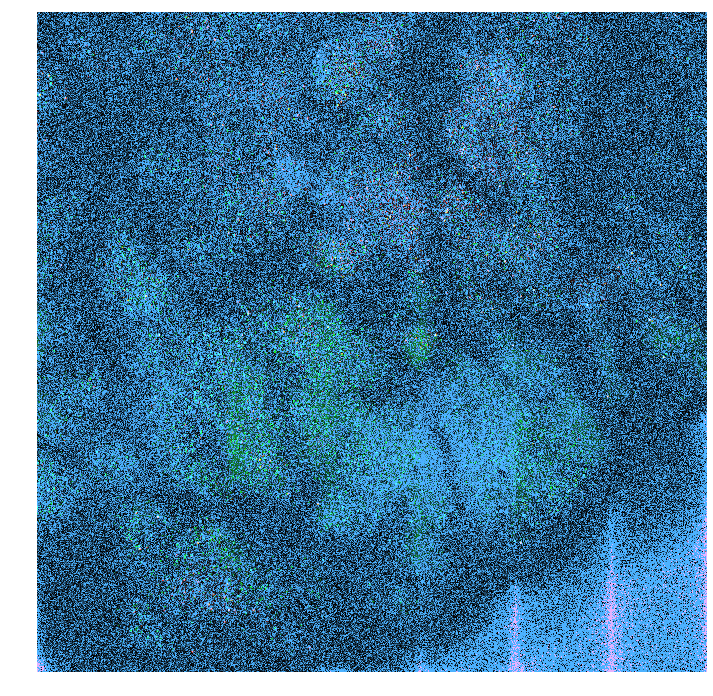

In [93]:
image(overlayR, size=12);

In [94]:
imsave((path + '/summary/rsqOverlayLCRD.tif', (255*overlayR).astype('uint8'), plugin='tifffile', photometric='rgb')

SyntaxError: invalid syntax (<ipython-input-94-336f17b3e483>, line 1)